In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [350]:
import pandas as pd

# 读取三个数据集
df_vix = pd.read_csv("daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("daily_sentiment_bert.csv", parse_dates=["date"])

# 筛选日期范围
start_date = "2017-02-28"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# 添加前缀：VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# 添加前缀：NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# 情感数据也筛选日期范围
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# 依次合并
df_merged = df_all.merge(df_sentiscores, on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# 查看缺失值
print("Missing values per column:")
print(df_merged.isnull().sum())

# 查看合并后的数据
print(df_merged.head())

# 保存结果
df_merged.to_csv("factor_data.csv", index=False)

Missing values per column:
date                     0
avg_sentiment_score      0
model_type               0
vix_open               567
vix_high               567
vix_low                567
vix_close              567
nvda_open              567
nvda_high              567
nvda_low               567
nvda_close             567
nvda_volume            567
dtype: int64
        date  avg_sentiment_score    model_type  vix_open  vix_high  vix_low  \
0 2017-02-28            -0.029851  FinBERT+BERT     12.19     12.96    12.13   
1 2017-03-01             0.075949  FinBERT+BERT     12.31     12.58    11.78   
2 2017-03-02             0.187500  FinBERT+BERT     12.43     12.71    11.32   
3 2017-03-03             0.014925  FinBERT+BERT     11.96     11.97    10.94   
4 2017-03-04            -0.142857  FinBERT+BERT       NaN       NaN      NaN   

   vix_close  nvda_open  nvda_high  nvda_low  nvda_close  nvda_volume  
0      12.92    2.58514    2.59484   2.48609     2.50336  614325793.0  
1      12.5

In [520]:
# 1. 数据预处理（假设df是已经合并的DataFrame）
def preprocess_data(df):
    # 确保date列存在
    if 'date' not in df.columns:
        raise ValueError("数据必须包含'date'列")
    
    # 设置日期索引
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # 处理缺失值
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    
    # 计算未来收益及技术因子
    df['future_5d_ret'] = df['nvda_close'].pct_change(5).shift(-5)
    df['nvda_momentum'] = df['nvda_close'].pct_change(5)
    df['nvda_volatility'] = df['nvda_close'].pct_change().rolling(5).std()
    df['nvda_volume_change'] = df['nvda_volume'].pct_change(5)
    df['volatility_20'] = df['nvda_close'].pct_change().rolling(20).std()

    
    return df

# 2. 因子构建
def build_enhanced_factors(df):
    """
    改进版因子构建：
    1. 情绪因子非线性处理
    2. VIX期限结构
    3. 技术因子PCA降维
    """
    factors = df.copy()
    
    # 1. 情绪因子二值化（只保留显著情绪）
    sentiment_threshold = factors['avg_sentiment_score'].std() * 1.5
    factors['sentiment_factor'] = np.where(
        factors['avg_sentiment_score'].abs() > sentiment_threshold,
        np.sign(factors['avg_sentiment_score']),  # 只保留方向
        0
    )
    
    # 2. VIX期限结构因子（近月-3个月均值）
    factors['vix_structure'] = factors['vix_close'] - factors['vix_close'].rolling(63).mean()
    factors['vix_factor'] = StandardScaler().fit_transform(factors[['vix_structure']])
    
    # 3. 技术因子PCA降维（去除冗余）
    tech_factors = factors[['nvda_momentum', 'nvda_volatility', 'nvda_volume_change']].dropna()
    pca = PCA(n_components=1)
    factors.loc[tech_factors.index, 'tech_factor'] = pca.fit_transform(
        StandardScaler().fit_transform(tech_factors))
    
    return factors

# 3. 综合指数构建
def build_composite_index(factors_df):
    # 选择因子列
    factor_cols = ['sentiment_factor', 'vix_factor', 'tech_factor']
    
    # 标准化因子
    factors_standardized = factors_df[factor_cols].apply(
        lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
    )
    
    composite_index = factors_standardized.mean(axis=1)
    return composite_index

# 4. 因子分析
def analyze_factors(factors_df, composite_index):
    # 因子相关性
    corr_matrix = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    print("因子相关性矩阵:\n", corr_matrix)
    
    # 因子与未来收益的IC分析
    def calculate_ic(factor, ret, lag=5):
        valid_idx = ~pd.isna(factor) & ~pd.isna(ret)
        return spearmanr(factor[valid_idx], ret[valid_idx]).correlation
    
    ic_results = {
        'sentiment': calculate_ic(factors_df['sentiment_factor'], factors_df['future_5d_ret']),
        'vix': calculate_ic(factors_df['vix_factor'], factors_df['future_5d_ret']),
        'tech': calculate_ic(factors_df['tech_factor'], factors_df['future_5d_ret'])
    }
    print("\n因子IC值（5日收益）:", ic_results)
    
    # 可视化综合指数
    plt.figure(figsize=(12, 6))
    composite_index.plot(title='Composite Index')
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

# 5. 回测策略
class EnhancedCompositeStrategy(Strategy):
    ma_short = 30
    ma_long = 50
    volatility_threshold = 0.015
    confirm_window = 3
    stop_loss_pct = 0.03
    take_profit_pct = 0.05

    def init(self):
        self.composite_index = self.data.composite_index
        self.volatility = self.data.volatility_20

        self.ma_short_series = self.I(lambda: pd.Series(self.composite_index).rolling(self.ma_short).mean().to_numpy())
        self.ma_long_series = self.I(lambda: pd.Series(self.composite_index).rolling(self.ma_long).mean().to_numpy())

        self.signal = self.I(self._generate_signals, name="Signal")

    def _generate_signals(self):
        index = pd.Series(self.composite_index, index=self.data.index)
        
        signals = pd.Series(0.0, index=index.index)
        
        # 条件 1: 指数上穿均线
        cond1 = (self.ma_short_series > self.ma_long_series)
    
        # 条件 2: 综合指数高于0（多因子一致看多）
        cond2 = index > 0
    
        # 条件 3: 波动率低于阈值
        cond3 = self.volatility < self.volatility_threshold
    
        # 合成信号：所有条件连续成立3天才买入
        buy_signal = (cond1 & cond2 & cond3).rolling(self.confirm_window).sum() == self.confirm_window
    
        signals[buy_signal] = 1.0
    
        return signals

    def next(self):
        if not self.signal[-1]:
            return

        try:
            # 如果未持仓，买入
            if not self.position:
                self.buy(size=1)

            # 如果已持仓，判断止盈/止损
            elif self.position:
                current_price = self.data.Close[-1]
                try:
                    entry_price = self.trades[-1].entry_price
                except:
                    print("[警告] 无法获取入场价格，跳过止盈/止损判断")
                    return
            
                if current_price >= entry_price * (1 + self.take_profit_pct) or \
                   current_price <= entry_price * (1 - self.stop_loss_pct):
                    print(f"止盈/止损触发, 当前价格: {current_price}, 入场价格: {entry_price}")
                    self.position.close()
        except Exception as e:
            print(f"[错误] 无法执行交易: {str(e)}")

In [521]:
# Visualization

def plot_factor_vs_price(df, composite_index):
    plt.figure(figsize=(14, 7))
    
    # 左轴：价格
    ax1 = plt.gca()
    ax1.plot(df.index, df['nvda_close'], color='tab:blue', label='NVDA Price')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.tick_params(axis='y', colors='tab:blue')
    
    # 右轴：综合指数
    ax2 = ax1.twinx()
    ax2.plot(df.index, composite_index, color='tab:orange', alpha=0.7, label='Composite Index')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_ylabel('Composite Index', color='tab:orange')
    ax2.tick_params(axis='y', colors='tab:orange')
    
    # 标注信号点（需回测后获取）
    if 'signal' in df.columns:
        buy_signals = df[df['signal'] == 1]
        sell_signals = df[df['signal'] == -1]
        ax1.scatter(buy_signals.index, buy_signals['nvda_close'], 
                   color='green', marker='^', alpha=1, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['nvda_close'],
                   color='red', marker='v', alpha=1, label='Sell')
        
    if 'ci_ma' in df.columns:
        ax2.plot(df.index, df['ci_ma'], color='tab:red', linestyle='--', label='Composite Index MA')
        
        plt.title('Composite Index vs NVDA Price with Trading Signals')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

def plot_factor_correlation(factors_df):
    plt.figure(figsize=(8, 6))
    corr = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Factor Correlation Matrix')
    plt.show()

def plot_factor_group_returns(factors_df):
    # 直接使用原始的二值化分组
    group_returns = factors_df.groupby('sentiment_factor')['future_5d_ret'].mean()
    
    # 重命名标签
    group_returns.index = ['Negative(-1)', 'Neutral(0)', 'Positive(1)']
    
    plt.figure(figsize=(10, 5))
    colors = ['red', 'gray', 'green']
    group_returns.plot(kind='bar', color=colors)
    
    # 添加统计显著性标记
    for i, v in enumerate(group_returns):
        plt.text(i, v, f"{v:.2%}", ha='center', va='bottom')
    
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title('Future 5-Day Returns by Sentiment Direction')
    plt.ylabel('Mean Return')
    plt.xlabel('Sentiment Group')
    plt.xticks(rotation=0)
    plt.show()

def enhanced_backtest_plots(returns, benchmark_returns):
    """
    绘制策略收益 vs 基准收益 的累计收益对比图。
    
    参数:
    - returns: 策略每日收益 (Series)
    - benchmark_returns: 基准每日收益 (Series)
    """

    # 对齐两个序列
    combined = pd.DataFrame({
        'strategy': returns,
        'benchmark': benchmark_returns
    }).dropna()

    # 累计收益
    cumulative = (1 + combined).cumprod()
    for year in pd.to_datetime(cumulative.index).year.unique():
        plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle=':', alpha=0.3)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)

    # 绘图
    plt.figure(figsize=(12, 6))   
    plt.text(0.02, 0.95, f'Sharpe: {sharpe:.2f}', transform=plt.gca().transAxes,fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.plot(cumulative.index, cumulative['strategy'], label='Strategy', linewidth=2)
    plt.plot(cumulative.index, cumulative['benchmark'], label='Benchmark', linestyle='--', linewidth=2)
    plt.title('Cumulative Returns: Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

原始数据形状: (1827, 12)
预处理后数据形状: (1827, 16)

生成因子分析可视化...


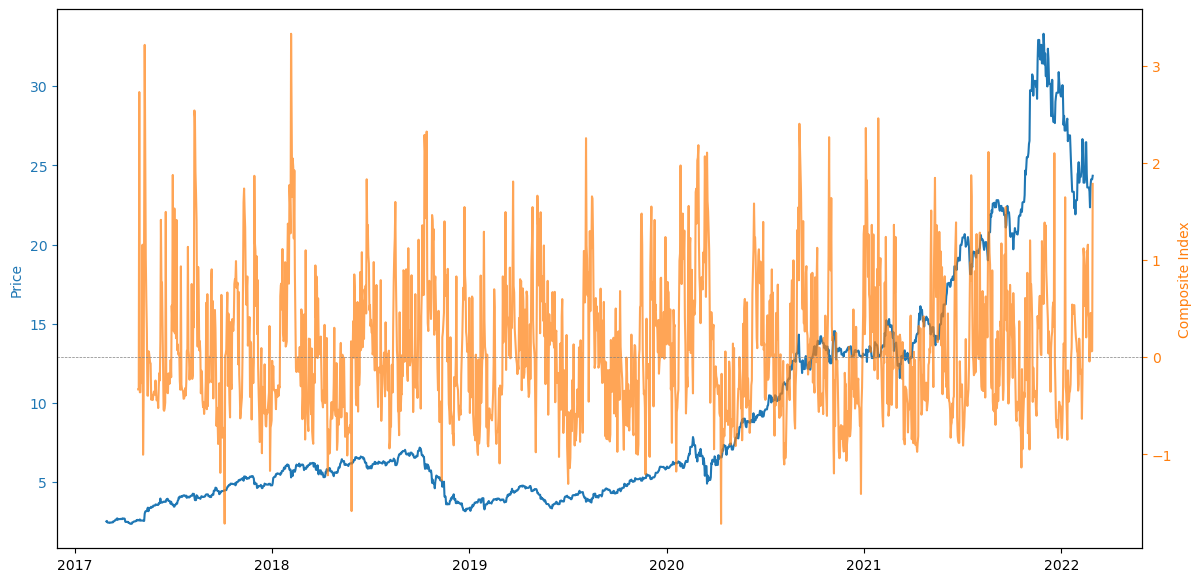

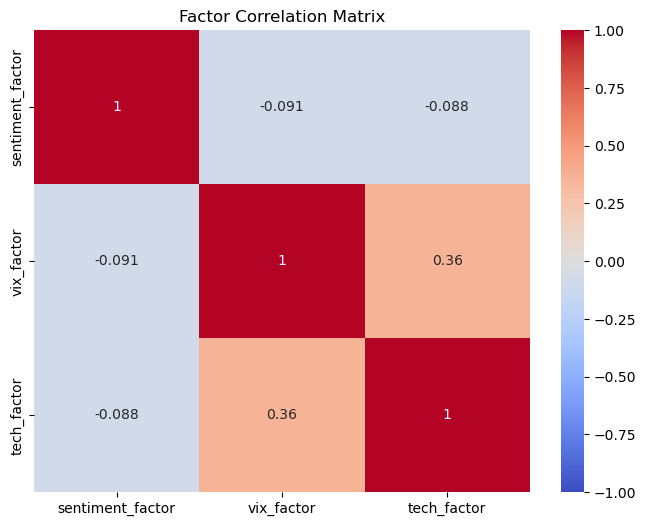

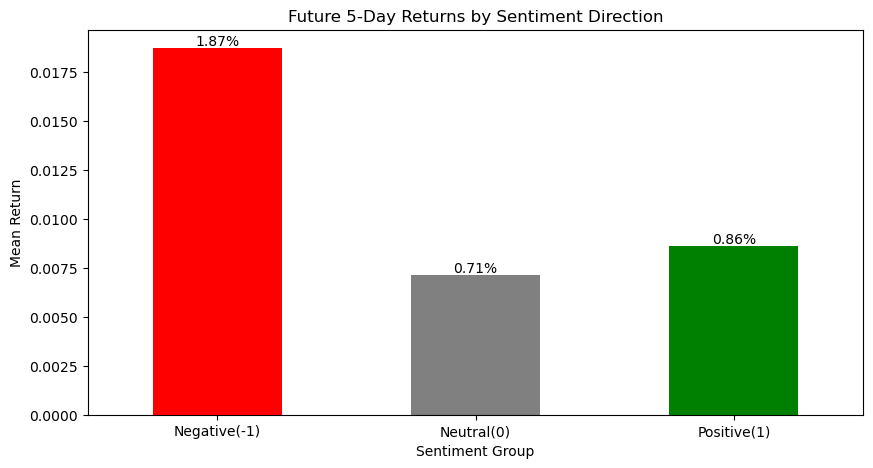

错误: "['composite_index'] not in index"


Traceback (most recent call last):
  File "/var/folders/zg/rg2_4mpd0m3f5zjhk_xzmhy00000gn/T/ipykernel_23803/2303757805.py", line 29, in main
    backtest_data = df[['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close',  # OHLC数据
  File "/Users/zhanghanshi/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py", line 3813, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
  File "/Users/zhanghanshi/anaconda3/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 6070, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/Users/zhanghanshi/anaconda3/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 6133, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['composite_index'] not in index"


In [524]:
def main():
    try:
        # 1. 加载数据
        df = pd.read_csv('factor_data.csv')
        print("原始数据形状:", df.shape)
        
        # 2. 预处理
        df = preprocess_data(df)
        print("预处理后数据形状:", df.shape)
        
        # 3. 构建因子
        factors = build_enhanced_factors(df)
        
        # 4. 综合指数
        factors['composite_index'] = build_composite_index(factors)
        
        # ========== 调用可视化函数 ==========
        print("\n生成因子分析可视化...")
        # 因子与价格对比图
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # 因子相关性热力图
        plot_factor_correlation(factors)
        
        # 因子分组收益
        plot_factor_group_returns(factors)
        
         # 5. 回测准备
        backtest_data = df[['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close',  # OHLC数据
        'volatility_20','composite_index' ]].copy()
        backtest_data.columns = ['Open', 'High', 'Low', 'close', 'volatility_20',  
        'composite_index']
        backtest_data['composite_index'] = factors['composite_index']  # 添加composite_index列
        backtest_data.dropna()

        # 6. 运行回测
        print("\n运行回测...")
        bt = Backtest(backtest_data, EnhancedCompositeStrategy, commission=0.0005, trade_on_close=True)
        results = bt.run()
        print(results)
        
        # 标注交易信号
        factors['signal'] = 0
        if hasattr(results, '_trades') and results._trades is not None:
            print(f"生成 {len(results._trades)} 笔交易")
            
            # 确保日期转换并标准化（去除时分秒）
            entry_dates = pd.to_datetime(results._trades['EntryTime']).dt.normalize()
            exit_dates = pd.to_datetime(results._trades['ExitTime']).dt.normalize()
            
            # 转换为日期字符串格式以匹配索引
            entry_dates = entry_dates.dt.strftime('%Y-%m-%d')
            exit_dates = exit_dates.dt.strftime('%Y-%m-%d')
            
            factors['signal'] = 0
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(entry_dates), 'signal'] = 1
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(exit_dates), 'signal'] = -1
        else:
            print("警告：没有生成任何交易")
        
        # 带信号的因子价格图
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # 策略每日收益
        equity_curve = results['_equity_curve']  # 注意这里是属性而不是字典
        returns = equity_curve['Equity'].pct_change().dropna()
        
        # 基准每日收益
        benchmark_returns = df['nvda_close'].loc[returns.index].pct_change().dropna()
        
        # 调用可视化函数
        enhanced_backtest_plots(returns, benchmark_returns)
        
    except Exception as e:
        print(f"错误: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()